In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os

os.chdir('/home/brian/Documents/CPS/data/')

In [22]:
cols = ['AGE', 'YEAR', 'MONTH', 'PWSSWGT', 'RETIRED', 'NILFREASON', 'LFS', 'FEMALE']

df = pd.read_feather(f'clean/cps2020.ft', columns=cols).query('MONTH == 2 and AGE >=15')

In [23]:
df.groupby('RETIRED').PWSSWGT.sum() / df.PWSSWGT.sum()

RETIRED
0    0.818602
1    0.181399
Name: PWSSWGT, dtype: float32

In [7]:
cols = ['AGE', 'YEAR', 'MONTH', 'BASICWGT', 'RETIRED', 'NILFREASON', 'LFS', 'FEMALE']

df = pd.read_feather(f'clean/cps2022.ft', columns=cols).query('AGE >= 40 and MONTH == 2')

<AxesSubplot:xlabel='AGE'>

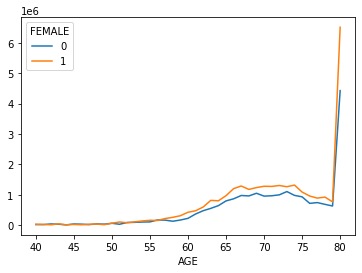

In [13]:
df.groupby(['FEMALE', 'AGE', 'NILFREASON']).BASICWGT.sum().unstack()['Retired'].unstack().T.plot()

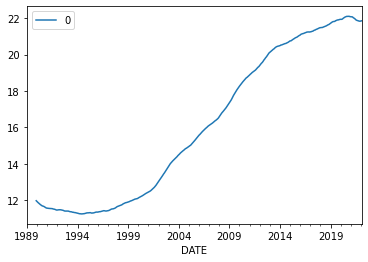

In [23]:
cols = ['AGE', 'YEAR', 'MONTH', 'BASICWGT', 'LFS']

df = pd.concat([pd.read_feather(f'clean/cps{year}.ft', columns=cols)
                  .query('LFS == "Employed"') 
                for year in range(1989, 2023)])

retage = (lambda x: x.query('AGE >= 55 and AGE <= 72').BASICWGT.sum()
                 / x.BASICWGT.sum())

data = (df.groupby(['YEAR', 'MONTH']).apply(retage)).reset_index()
data['DATE'] = pd.to_datetime(dict(year=data.YEAR, month=data.MONTH, day=1))
data = data.set_index('DATE').drop(['YEAR', 'MONTH'], axis=1) * 100

data.rolling(12).mean().plot();

In [22]:
df.groupby(['YEAR', 'MONTH']).AGE.agg(pd.Series.mode)

YEAR  MONTH
1989  1              28
      2              32
      3              32
      4              32
      5              32
                 ...   
2021  10             40
      11             40
      12             41
2022  1              41
      2        [40, 51]
Name: AGE, Length: 398, dtype: object

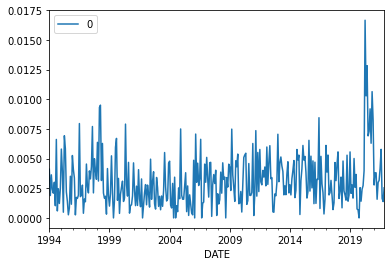

In [6]:
cols = ['AGE', 'YEAR', 'MONTH', 'BASICWGT', 'RETIRED', 'NILFREASON', 'PERET1', 'DWTYPE']

df = pd.concat([pd.read_feather(f'clean/cps{year}.ft', columns=cols)
                  .query('AGE >= 16') 
                for year in range(1994, 2022)])

wantjob = (lambda x: x.query('PERET1 == 3').BASICWGT.sum()
                 / x.BASICWGT.sum())

data = (df.groupby(['YEAR', 'MONTH']).apply(wantjob)).reset_index()
data['DATE'] = pd.to_datetime(dict(year=data.YEAR, month=data.MONTH, day=1))
data = data.set_index('DATE').drop(['YEAR', 'MONTH'], axis=1) * 100

data.plot();

In [13]:
d = df.query('YEAR == 2021 and MONTH == 11')

In [16]:
d.groupby('NILFREASON').BASICWGT.sum() / d.BASICWGT.sum()

NILFREASON
Disabled/Ill    0.052731
Discouraged     0.020905
Family          0.048689
Other           0.007153
Retired         0.195889
School          0.056001
nan             0.618631
Name: BASICWGT, dtype: float32

In [37]:
# Age and sex demographics in March 2001
filter_cols = ['AGE', 'FEMALE', 'NILFREASON', 'BASICWGT', 'MONTH', 
               'RETIRED', 'LFS', 'PERET1']
df = (pd.read_feather('clean/cps2001.ft', columns=filter_cols)
        .query('MONTH == 3 and 55 <= AGE <= 64'))

# Create dictionary with sex and age distribution in March 2001
dem_2001 = {}
for sex in [0, 1]:
    dfs = df[df['FEMALE'] == sex]
    age_dict = (dfs.groupby('AGE').BASICWGT.sum()
                / dfs.BASICWGT.sum()).to_dict()
    for age in age_dict.keys():
        dem_2001[(sex, age)] = age_dict[age]

In [38]:
results = pd.DataFrame()
for year in range(2000, 2022):
    annual_data = (pd.read_feather(f'clean/cps{year}.ft', columns=filter_cols)
                     .query('55 <= AGE <= 64'))
    for month, df in annual_data.groupby('MONTH'):
    
        date = pd.to_datetime(f'{year}-{month}-01')

        dem_adj = {}
        for sex in [0, 1]:
            dfs = df[df['FEMALE'] == sex]
            age_dict = (dfs.groupby('AGE').BASICWGT.sum()
                        / dfs.BASICWGT.sum()).to_dict()
            for age in age_dict.keys():
                dem_adj[(sex, age)] = dem_2001[(sex, age)] / age_dict[age]

        df['COMBO'] = list(zip(df['FEMALE'], df['AGE']))
        df['ADJWGT'] = df['COMBO'].map(dem_adj) * df['BASICWGT']

        s = df.groupby('NILFREASON').ADJWGT.sum() / df.ADJWGT.sum()
        unadj = (df.groupby('NILFREASON').BASICWGT.sum()
                 / df.BASICWGT.sum()).nan
        monthly_result = s.to_frame(name=date).T
        monthly_result.at[date, 'nan'] = s.nan - unadj

        results = results.append(monthly_result)

results = results.rename({'nan': 'Demographics'}, axis=1).rolling(12).mean()
results = results.dropna().loc['2001-03-01':] * 100
final = results.iloc[0] - results

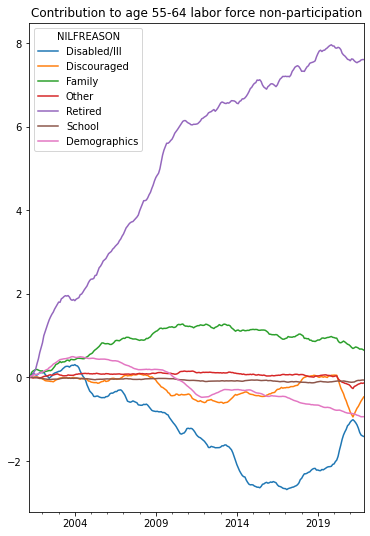

In [39]:
title='Contribution to age 55-64 labor force non-participation'
final.plot(figsize=(6, 9), title=title);